<a href="https://colab.research.google.com/github/naufalfrdss/DeepLearning/blob/main/Week%203/Assignment/SVHN%20Dataset/SVHN_Using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


## Data Preparation

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_dataset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

# Optional validation split
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


100.0%


100.0%


## CNN Model

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # 32x16x16
        x = self.pool(F.relu(self.conv2(x)))   # 64x8x8
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
def train_model(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0, 0
    for data, target in loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def eval_model(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()

            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

            all_preds.extend(pred.numpy())
            all_targets.extend(target.numpy())
    return total_loss / len(loader), correct / len(loader.dataset), all_preds, all_targets


In [5]:
cnn = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_model(cnn, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _ = eval_model(cnn, val_loader, criterion)
    print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")


Epoch 1: Train Acc = 0.6792, Val Acc = 0.8541
Epoch 2: Train Acc = 0.8673, Val Acc = 0.8789
Epoch 3: Train Acc = 0.8900, Val Acc = 0.8880
Epoch 4: Train Acc = 0.9047, Val Acc = 0.8976
Epoch 5: Train Acc = 0.9192, Val Acc = 0.9007
Epoch 6: Train Acc = 0.9302, Val Acc = 0.8986
Epoch 7: Train Acc = 0.9403, Val Acc = 0.8998
Epoch 8: Train Acc = 0.9490, Val Acc = 0.9000
Epoch 9: Train Acc = 0.9571, Val Acc = 0.9014
Epoch 10: Train Acc = 0.9636, Val Acc = 0.8998


### Evaluate CNN Model

Test Accuracy: 0.8807237246465888
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1744
           1       0.94      0.92      0.93      5099
           2       0.94      0.90      0.92      4149
           3       0.80      0.87      0.83      2882
           4       0.91      0.88      0.90      2523
           5       0.89      0.86      0.87      2384
           6       0.86      0.83      0.84      1977
           7       0.88      0.90      0.89      2019
           8       0.77      0.85      0.81      1660
           9       0.79      0.87      0.83      1595

    accuracy                           0.88     26032
   macro avg       0.87      0.87      0.87     26032
weighted avg       0.88      0.88      0.88     26032



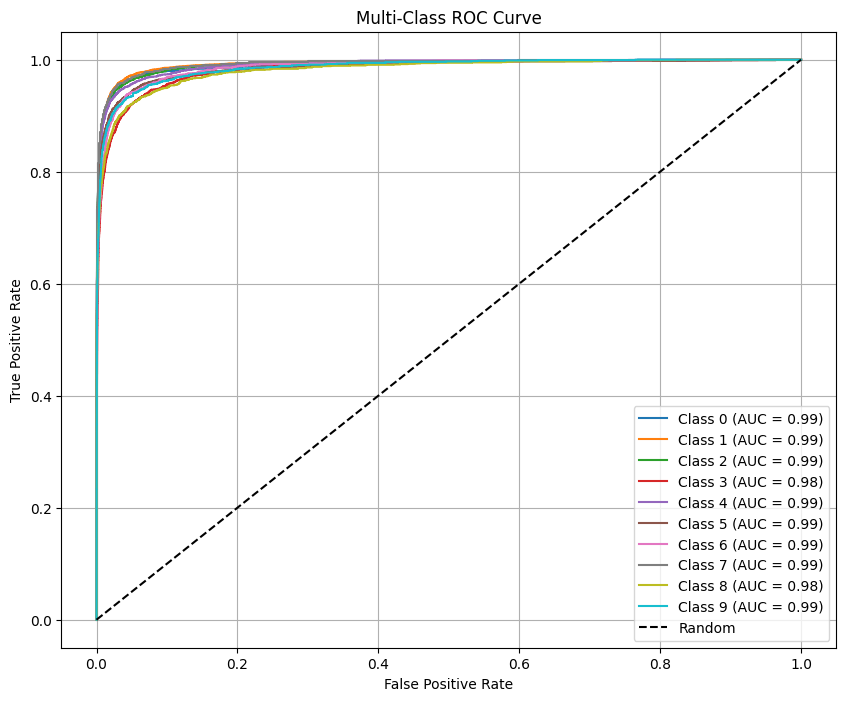

In [9]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

# Set model ke eval mode
cnn.eval()

# Simpan semua prediksi probabilitas dan label asli
all_probs = []
all_targets = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = cnn(inputs)
        probs = torch.softmax(outputs, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_targets.append(labels.cpu().numpy())
        all_preds.append(torch.argmax(probs, dim=1).cpu().numpy())

# Gabungkan seluruh batch
preds_prob = np.concatenate(all_probs, axis=0)
targets = np.concatenate(all_targets, axis=0)
preds = np.concatenate(all_preds, axis=0)

# Print akurasi & classification report
print("Test Accuracy:", (preds == targets).mean())
print(classification_report(targets, preds))

# Binarisasi label untuk ROC-AUC
targets_bin = label_binarize(targets, classes=range(10))

# Hitung ROC dan AUC untuk setiap kelas
fpr, tpr, roc_auc = {}, {}, {}
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(targets_bin[:, i], preds_prob[:, i])
    roc_auc[i] = roc_auc_score(targets_bin[:, i], preds_prob[:, i])

# Plot semua ROC
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## MLP Model

In [10]:
class FlattenedSVHN(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        image, label = self.dataset[index]
        image = image.view(-1)  # Flatten the image (3*32*32 = 3072)
        return image, label

    def __len__(self):
        return len(self.dataset)

train_dataset_mlp = FlattenedSVHN(train_dataset)
val_dataset_mlp = FlattenedSVHN(val_dataset)
test_dataset_mlp = FlattenedSVHN(test_dataset)

train_loader_mlp = DataLoader(train_dataset_mlp, batch_size=128, shuffle=True)
val_loader_mlp = DataLoader(val_dataset_mlp, batch_size=128, shuffle=False)
test_loader_mlp = DataLoader(test_dataset_mlp, batch_size=128, shuffle=False)

In [11]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
mlp = MLP()
criterion_mlp = nn.CrossEntropyLoss()
optimizer_mlp = optim.Adam(mlp.parameters(), lr=0.001)

for epoch in range(10):
    train_loss, train_acc = train_model(mlp, train_loader_mlp, criterion_mlp, optimizer_mlp)
    val_loss, val_acc, _, _ = eval_model(mlp, val_loader_mlp, criterion_mlp)
    print(f"[MLP] Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")


[MLP] Epoch 1: Train Acc = 0.5886, Val Acc = 0.7176
[MLP] Epoch 2: Train Acc = 0.7413, Val Acc = 0.7642
[MLP] Epoch 3: Train Acc = 0.7835, Val Acc = 0.7849
[MLP] Epoch 4: Train Acc = 0.8057, Val Acc = 0.8023
[MLP] Epoch 5: Train Acc = 0.8223, Val Acc = 0.7954
[MLP] Epoch 6: Train Acc = 0.8335, Val Acc = 0.8075
[MLP] Epoch 7: Train Acc = 0.8458, Val Acc = 0.8217
[MLP] Epoch 8: Train Acc = 0.8529, Val Acc = 0.8215
[MLP] Epoch 9: Train Acc = 0.8600, Val Acc = 0.8212
[MLP] Epoch 10: Train Acc = 0.8683, Val Acc = 0.8099


### Evaluate MLP

In [13]:
test_loss_mlp, test_acc_mlp, preds_mlp, targets_mlp = eval_model(mlp, test_loader_mlp, criterion_mlp)
print("MLP Test Accuracy:", test_acc_mlp)

print(classification_report(targets_mlp, preds_mlp))

MLP Test Accuracy: 0.7785802089735709
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      1744
           1       0.84      0.84      0.84      5099
           2       0.86      0.82      0.84      4149
           3       0.75      0.70      0.72      2882
           4       0.81      0.80      0.81      2523
           5       0.75      0.77      0.76      2384
           6       0.74      0.72      0.73      1977
           7       0.76      0.80      0.78      2019
           8       0.61      0.73      0.67      1660
           9       0.67      0.74      0.70      1595

    accuracy                           0.78     26032
   macro avg       0.76      0.76      0.76     26032
weighted avg       0.78      0.78      0.78     26032



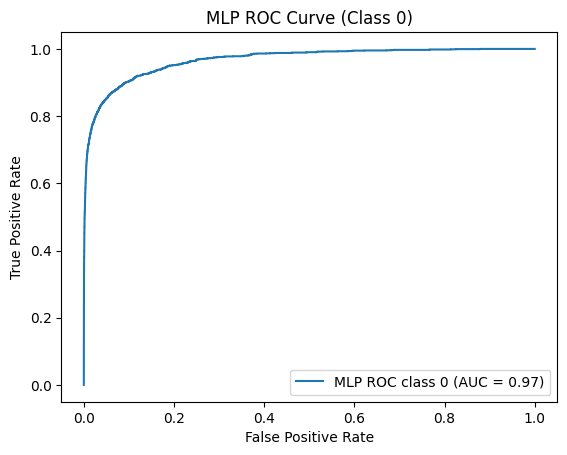

In [14]:
# Binarize targets
targets_bin_mlp = label_binarize(targets_mlp, classes=range(10))

# Get prediction probabilities
mlp.eval()
all_probs_mlp = []
with torch.no_grad():
    for x, _ in test_loader_mlp:
        prob = F.softmax(mlp(x), dim=1)
        all_probs_mlp.append(prob)
all_probs_mlp = torch.cat(all_probs_mlp).numpy()

# ROC & AUC per class
fpr_mlp = dict()
tpr_mlp = dict()
roc_auc_mlp = dict()

for i in range(10):
    fpr_mlp[i], tpr_mlp[i], _ = roc_curve(targets_bin_mlp[:, i], all_probs_mlp[:, i])
    roc_auc_mlp[i] = roc_auc_score(targets_bin_mlp[:, i], all_probs_mlp[:, i])

plt.plot(fpr_mlp[0], tpr_mlp[0], label=f'MLP ROC class 0 (AUC = {roc_auc_mlp[0]:.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("MLP ROC Curve (Class 0)")
plt.show()

## Persamaan Matematis

Arsitektur :

1. Conv2D: Operasi konvolusi 2D

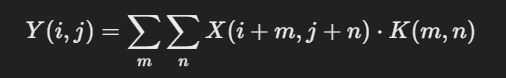

Diimplementasikan oleh:
**nn.Conv2d (PyTorch)**

2. ReLU (Rectified Linear Unit)

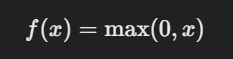

3. MaxPooling2D: Mengambil nilai maksimum dari window
Reduksi dimensi, meningkatkan translational invariance.

4. Flatten: Ubah matriks menjadi vektor 1D sebelum Fully Connected layer.

5. Dense / Linear:

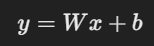

6. Softmax (output):

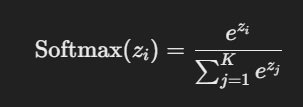

Akurasi:

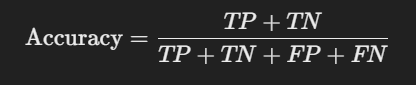

Presisi

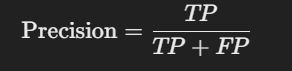

Recall, Kemampuan model dalam menemukan semua data positif:

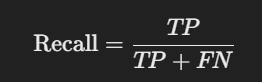

F1 Score
Harmonik rata-rata antara presisi dan recall:

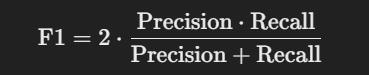

AUC (Area Under Curve)
Mengukur kemampuan model dalam membedakan antara kelas:

Area di bawah kurva ROC (semakin mendekati 1, semakin baik)

ROC Curve (Receiver Operating Characteristic)
Plot antara TPR (True Positive Rate) dan FPR (False Positive Rate):

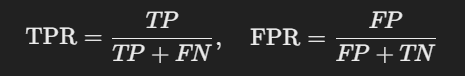